In [1]:
from utils import *
# Tensorflow
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
import pca_script
import matplotlib.pyplot as plt
import imblearn
from collections import Counter

In [2]:
public_data_path, metadata_path = define_paths()
x_df, y_df = load_XY_dfs(public_data_path)
y_df = y_df.drop(['start', 'end'], axis =1)

x_df = forward_fill_impute(x_df)
X, y = impute_none_labels(x_df.values, y_df.values)

# Get the argmax of y (requires removing nans with zero) - First make Y back into a df
y_df = pd.DataFrame(data = y, columns = y_df.columns)
y_df = y_df.fillna(0)
y_max = np.argmax(y_df.values,axis=1)

<AxesSubplot:title={'center':'Label Distributions'}>

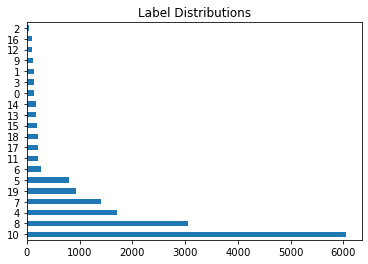

In [24]:
def graph_y_hist_and_maj_class_baseline(y_max, y_df):
    Y_series = pd.Series(data=y_max)
    Y_counts = Y_series.value_counts()
    Y_counts.index = [y_df.columns[i] for i in list(Y_counts.index)]
    Y_counts.plot(kind='barh', title='Label Distributions')
    return max(Y_counts)/Y_counts.sum() * 100, Y_series.value_counts()
# baseline_score, Y_count = graph_y_hist_and_maj_class_baseline(y_max, y_df)


In [4]:
# First make a classificiation with a decision tree classifier
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE

model= DecisionTreeClassifier()
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y_max, scoring='f1_macro', cv=cv)#, n_jobs=-1)
print('F1: %.3f' % mean(scores))


F1: 0.312


In [5]:
# The define a pipeline - incorporating SMOTE - but SMOTE is just gonna wildly oversample at this point. 
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
steps = [('over', SMOTE()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)
scores = cross_val_score(pipeline, X, y_max, scoring='f1_macro', cv=cv)#, n_jobs=-1)
print('f1 macro: %.3f' % mean(scores))

f1 macro: 0.311


In [25]:
def get_sample_strategy(Y_counts):
    keys = list(Y_counts.index)
    vals = list(Y_counts.values)
    strategy = dict(zip(keys,vals))

    under_samples = [8,10]
    for i in under_samples:
        strategy[i] -= round(strategy[i]/3)

    over_samples = keys[6:9]
    for i in over_samples:
        strategy[i] += round(strategy[i]*5)

    return strategy

In [26]:
#SMOTE is better when you combine it with undersampling of the majority class - e.g use random undersampling
# Then define your ratio of minorty to majority classes. 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# define pipeline
strategy = get_sample_strategy(Y_counts)
model = DecisionTreeClassifier()
over = SMOTE(sampling_strategy=strategy)
under = RandomUnderSampler(sampling_strategy=strategy)
# steps = [('over', over), ('under', under), ('model', model)]
steps = [('over', over), ('model', model)]
pipeline = Pipeline(steps=steps)

# Then evaluate the pipeline again
scores = cross_val_score(pipeline, X, y_max, scoring='f1_macro', cv=cv)#, n_jobs=-1)
print('f1 macro: %.3f' % mean(scores))

/Users/fl20994/opt/anaconda3/envs/sphere_env/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (4032) in class 10 will be larger than the number of samples in the majority class (class #10 -> 3024)
  f"After over-sampling, the number of samples ({n_samples})"
/Users/fl20994/opt/anaconda3/envs/sphere_env/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (4032) in class 10 will be larger than the number of samples in the majority class (class #10 -> 3024)
  f"After over-sampling, the number of samples ({n_samples})"
/Users/fl20994/opt/anaconda3/envs/sphere_env/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (4032) in class 10 will be larger than the number of samples in the majority class (class #10 -> 3024)
  f"After over-sampling, the number of samples ({n_samples})"
/Users/fl2099

<AxesSubplot:title={'center':'Balanced Data'}>

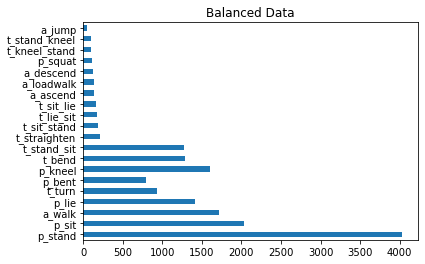

In [27]:
# Plot the new strategy distribution -= comparison with old distribution
dist = pd.Series(data=strategy)
dist.index = [y_df.columns[i] for i in list(dist.index)]

dist.plot(kind='barh', title = 'Balanced Data')

# Below is attempt 1 for SMOTE

In [16]:
from imblearn.over_sampling import SMOTE

# scatter plot of examples by class label
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(x_df.values, Y)


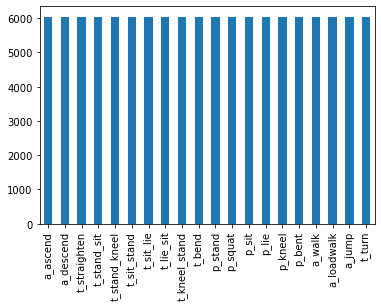

In [17]:
graph_y_hist(y, y_df)
# pd.Series(data=y).value_counts().plot(kind='bar')

In [26]:
# define baseline model
#(alt loss = categorical_crossentropy)
train_x, test_x, train_y, test_y = train_test_split(X,y)


n_features = train_x.shape[1]
n_labels = len(set(train_y))

def baseline_model():
    """ Multilayer perceptron model - using relative cross entropy loss (KL-Divergence) for comparing 
    probability distributions """
	# create model
    model = Sequential()
    model.add(Dense(10, input_dim=n_features, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(n_labels, activation='softmax'))
    # Compile model
    model.compile(loss='kullback_leibler_divergence', optimizer='adam', metrics=['accuracy'])
    return model

In [28]:
model = baseline_model()
history = model.fit(train_x, train_y, epochs=150, batch_size=32, verbose =0)

In [ ]:
loss, acc = model.evaluate(test_x, test_y, verbose=0)
print(f'Test Accuracy: {acc}')
print(f'Test Loss: {loss}')